<a href="https://colab.research.google.com/github/EmanueleCosenza/Polyphemus/blob/main/midi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/home/cosenza/thesis/Polyphemus


In [2]:
!git branch

  main
* sparse


Libraries installation

In [3]:
#!tar -C data -xvzf data/lmd_matched.tar.gz

In [4]:
# Install the required music libraries
#!pip3 install muspy
#!pip3 install pypianoroll

In [5]:
# Install torch_geometric
#!v=$(python3 -c "import torch; print(torch.__version__)"); \
#pip3 install torch-scatter -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-sparse -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-geometric

Reproducibility

In [6]:
import numpy as np
import torch
import random
import os

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42
set_seed(seed)

In [7]:
import os
import muspy
from itertools import product
import pypianoroll as pproll
import time
from tqdm.auto import tqdm


class MIDIPreprocessor():
    
    def __init__():
        pass

    def preprocess_dataset(self, dir, early_exit=None):
        pass
    
    def preprocess_file(self, f):
        pass


# Todo: to config file (or separate files)
MAX_SIMU_NOTES = 16 # 14 + SOS and EOS

PITCH_SOS = 128
PITCH_EOS = 129
PITCH_PAD = 130
DUR_PAD_IND = 2
MAX_DUR = 511 # equivalent to 16 bars (with RESOLUTION=32)

# Number of time steps per quarter note.
RESOLUTION = 8 
NUM_BARS = 1


def preprocess_file(filepath, dest_dir, num_samples):

    saved_samples = 0

    print("Preprocessing file " + filepath)

    # Load the file both as a pypianoroll song and a muspy song
    # (Need to load both since muspy.to_pypianoroll() is expensive)
    try:
        pproll_song = pproll.read(filepath, resolution=RESOLUTION)
        muspy_song = muspy.read(filepath)
    except Exception as e:
        print("Song skipped (Invalid song format)")
        return 0
    
    # Only accept songs that have a time signature of 4/4 and no time changes
    for t in muspy_song.time_signatures:
        if t.numerator != 4 or t.denominator != 4:
            print("Song skipped ({}/{} time signature)".
                            format(t.numerator, t.denominator))
            return 0

    # Gather tracks of pypianoroll song based on MIDI program number
    drum_tracks = []
    bass_tracks = []
    guitar_tracks = []
    strings_tracks = []

    for track in pproll_song.tracks:
        if track.is_drum:
            track.name = 'Drums'
            drum_tracks.append(track)
        elif 0 <= track.program <= 31:
            track.name = 'Guitar'
            guitar_tracks.append(track)
        elif 32 <= track.program <= 39:
            track.name = 'Bass'
            bass_tracks.append(track)
        else:
            # Tracks with program > 39 are all considered as strings tracks
            # and will be merged into a single track later on
            strings_tracks.append(track)

    # Filter song if it does not contain drum, guitar, bass or strings tracks
    if not drum_tracks or not guitar_tracks \
       or not bass_tracks or not strings_tracks:
        print("Song skipped (does not contain drum or "
                "guitar or bass or strings tracks)")
        return 0
    
    # Merge strings tracks into a single pypianoroll track
    strings = pproll.Multitrack(tracks=strings_tracks)
    strings_track = pproll.Track(pianoroll=strings.blend(mode='max'),
                                 program=48, name='Strings')

    combinations = list(product(drum_tracks, bass_tracks, guitar_tracks))

    # Single instruments can have multiple tracks.
    # Consider all possible combinations of drum, bass, and guitar tracks
    for i, combination in enumerate(combinations):

        print("Processing combination", i+1, "of", len(combinations))
        
        # Process combination (called 'subsong' from now on)
        drum_track, bass_track, guitar_track = combination
        tracks = [drum_track, bass_track, guitar_track, strings_track]
        
        pproll_subsong = pproll.Multitrack(
            tracks=tracks,
            tempo=pproll_song.tempo,
            resolution=RESOLUTION
        )
        muspy_subsong = muspy.from_pypianoroll(pproll_subsong)
        
        tracks_notes = [track.notes for track in muspy_subsong.tracks]
        
        # Obtain length of subsong (maximum of each track's length)
        length = 0
        for notes in tracks_notes:
            track_length = max(note.end for note in notes) if notes else 0
            length = max(length, track_length)
        length += 1

        # Add timesteps until length is a multiple of RESOLUTION
        length = length if length%(RESOLUTION*4) == 0 \
                            else length + (RESOLUTION*4-(length%(RESOLUTION*4)))


        tracks_tensors = []
        tracks_activations = []

        dur_bin_length = int(np.ceil(np.log2(MAX_DUR)))

        # Todo: adapt to velocity
        for notes in tracks_notes:

            # Initialize encoder-ready track tensor
            # track_tensor: (length x max_simu_notes x 2 (or 3 if velocity))
            # The last dimension contains pitches and durations (and velocities)
            # int16 is enough for small to medium duration values
            track_tensor = np.zeros((length, MAX_SIMU_NOTES, 2), np.int16)

            track_tensor[:, :, 0] = PITCH_PAD
            track_tensor[:, 0, 0] = PITCH_SOS

            # Keeps track of how many notes have been stored in each timestep
            # (int8 imposes that MAX_SIMU_NOTES < 256)
            notes_counter = np.ones(length, dtype=np.int8)

            # Todo: np.put_along_axis?
            for note in notes:
                # Insert note in the lowest position available in the timestep
                
                t = note.time

                if notes_counter[t] >= MAX_SIMU_NOTES-1:
                    # Skip note if there is no more space
                    continue

                track_tensor[t, notes_counter[t], 0] = note.pitch
                track_tensor[t, notes_counter[t], 1] = note.duration
                notes_counter[t] += 1
            
            # Add end of sequence token
            track_tensor[np.arange(0, length), notes_counter, 0] = PITCH_EOS

            # Get track activations, a boolean tensor indicating whether notes
            # are being played in a timestep (sustain does not count)
            # (needed for graph rep.)
            activations = np.array(notes_counter-1, dtype=bool)

            tracks_tensors.append(track_tensor)
            tracks_activations.append(activations)
        
        # (#tracks x length x max_simu_notes x 2 (or 3))
        subsong_tensor = np.stack(tracks_tensors, axis=0)

        # (#tracks x length)
        subsong_activations = np.stack(tracks_activations, axis=0)


        # Slide window over 'subsong_tensor' and 'subsong_activations' along the
        # time axis (2nd dimension) with the stride of a bar
        # Todo: np.lib.stride_tricks.as_strided(song_proll)
        for i in range(0, length-NUM_BARS*RESOLUTION*4+1, RESOLUTION*4):
            
            # Get the sequence and its activations
            seq_tensor = subsong_tensor[:, i:i+NUM_BARS*RESOLUTION*4, :]
            seq_acts = subsong_activations[:, i:i+NUM_BARS*RESOLUTION*4]
            seq_tensor = np.copy(seq_tensor)
            seq_acts = np.copy(seq_acts)

            if NUM_BARS > 1:
                # Skip sequence if it contains more than one bar of consecutive
                # silence in at least one track
                bars = seq_acts.reshape(seq_acts.shape[0], NUM_BARS, -1)
                bars_acts = np.any(bars, axis=2)

                if 1 in np.diff(np.where(bars_acts == 0)[1]):
                    continue
            else:
                # In the case of just 1 bar, skip it if all tracks are silenced
                bar_acts = np.any(seq_acts, axis=1)
                if not np.any(bar_acts):
                    continue
            

            # Randomly transpose the pitches of the sequence (-5 to 6 semitones)
            # Not considering pad, sos, eos tokens
            # Not transposing drums/percussions
            shift = np.random.choice(np.arange(-5, 7), 1)
            cond = (seq_tensor[1:, :, :, 0] != PITCH_PAD) &                     \
                   (seq_tensor[1:, :, :, 0] != PITCH_SOS) &                     \
                   (seq_tensor[1:, :, :, 0] != PITCH_EOS)
            non_perc = seq_tensor[1:, ...]
            non_perc[cond, 0] += shift

            # Save sample (seq_tensor and seq_acts) to file
            curr_sample = str(num_samples + saved_samples)
            sample_filepath = os.path.join(dest_dir, curr_sample)
            np.savez(sample_filepath, seq_tensor=seq_tensor, seq_acts=seq_acts)

            saved_samples += 1


    print("File preprocessing finished. Saved samples:", saved_samples)
    print()

    return saved_samples



# Total number of files: 116189
# Number of unique files: 45129
def preprocess_dataset(dataset_dir, dest_dir, num_files=45129, early_exit=None):

    files_dict = {}
    seen = 0
    tot_samples = 0
    not_filtered = 0
    finished = False
    
    print("Starting preprocessing")
    
    progress_bar = tqdm(range(early_exit)) if early_exit is not None else tqdm(range(num_files))
    start = time.time()

    # Visit recursively the directories inside the dataset directory
    for dirpath, dirs, files in os.walk(dataset_dir):

        # Sort alphabetically the found directories
        # (to help guess the remaining time) 
        dirs.sort()
        
        print("Current path:", dirpath)
        print()

        for f in files:
            
            seen += 1

            if f in files_dict:
                # Skip already seen file
                files_dict[f] += 1
                continue

            # File never seen before, add to dictionary of files
            # (from filename to # of occurrences)
            files_dict[f] = 1

            # Preprocess file
            filepath = os.path.join(dirpath, f)
            n_saved = preprocess_file(filepath, dest_dir, tot_samples)

            tot_samples += n_saved
            if n_saved > 0:
                not_filtered += 1
            
            progress_bar.update(1)
            
            # Todo: also print # of processed (not filtered) files
            #       and # of produced sequences (samples)
            print("Total number of seen files:", seen)
            print("Number of unique files:", len(files_dict))
            print("Total number of non filtered songs:", not_filtered)
            print("Total number of saved samples:", tot_samples)
            print()

            # Exit when a maximum number of files has been processed (if set)
            if early_exit != None and len(files_dict) >= early_exit:
                finished = True
                break

        if finished:
            break
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Preprocessing completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
              .format(int(hours),int(minutes),seconds))


In [8]:
!rm -rf data/preprocessed/
!mkdir data/preprocessed

In [9]:
dataset_dir = 'data/lmd_matched/Y/G/'
dest_dir = 'data/preprocessed'

Check preprocessed data:

In [10]:
preprocess_dataset(dataset_dir, dest_dir, early_exit=10)

Starting preprocessing


  0%|          | 0/10 [00:00<?, ?it/s]

Current path: data/lmd_matched/Y/G/

Current path: data/lmd_matched/Y/G/B

Current path: data/lmd_matched/Y/G/B/TRYGBID128F42A74CF

Preprocessing file data/lmd_matched/Y/G/B/TRYGBID128F42A74CF/158bfccbf647b4c88bd98ba705fd4832.mid
Song skipped (does not contain drum or guitar or bass or strings tracks)
Total number of seen files: 1
Number of unique files: 1
Total number of non filtered songs: 0
Total number of saved samples: 0

Preprocessing file data/lmd_matched/Y/G/B/TRYGBID128F42A74CF/96b527d6b0774a59583ff83707c9012c.mid
Song skipped (does not contain drum or guitar or bass or strings tracks)
Total number of seen files: 2
Number of unique files: 2
Total number of non filtered songs: 0
Total number of saved samples: 0

Current path: data/lmd_matched/Y/G/B/TRYGBUJ12903CFC651

Preprocessing file data/lmd_matched/Y/G/B/TRYGBUJ12903CFC651/4eb991152d72121d226c6a32f9397484.mid
Processing combination 1 of 1
File preprocessing finished. Saved samples: 155

Total number of seen files: 3
Number

In [11]:
filepath = os.path.join(dest_dir, "5.npz")
data = np.load(filepath)

In [12]:
print(data["seq_tensor"].shape)
print(data["seq_acts"].shape)

(4, 32, 16, 2)
(4, 32)


In [13]:
data["seq_tensor"][0, 0]

array([[128,   0],
       [ 36,   1],
       [129,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0]], dtype=int16)

# Model

In [14]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.data import Data
import itertools


def unpackbits(x, num_bits):

    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")

    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])

    return (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])


class MIDIDataset(Dataset):

    def __init__(self, dir):
        self.dir = dir

    def __len__(self):
        _, _, files = next(os.walk(self.dir))
        return len(files)

    
    def __get_track_edges(self, acts, edge_type_ind=0):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        
        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        track_edges = []

        for track in range(a_t.shape[1]):
            tr_inds = list(inds[inds[:,1] == track])
            e_inds = [(tr_inds[i],
                    tr_inds[i+1]) for i in range(len(tr_inds)-1)]
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, e[1][0]-e[0][0]) for e in e_inds]
            track_edges.extend(edges)

        return np.array(track_edges, dtype='long')

    
    def __get_onset_edges(self, acts, edge_type_ind=1):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        onset_edges = []

        for i in ts_inds:
            ts_acts_inds = list(inds[inds[:,0] == i])
            if len(ts_acts_inds) < 2:
                continue
            e_inds = list(itertools.combinations(ts_acts_inds, 2))
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, 0) for e in e_inds]
            inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
            onset_edges.extend(edges)
            onset_edges.extend(inv_edges)

        return np.array(onset_edges, dtype='long')


    def __get_next_edges(self, acts, edge_type_ind=2):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        next_edges = []

        for i in range(len(ts_inds)-1):

            ind_s = ts_inds[i]
            ind_e = ts_inds[i+1]
            s = inds[inds[:,0] == ind_s]
            e = inds[inds[:,0] == ind_e]

            e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
            edges = [(labels[tuple(e[0])],labels[tuple(e[1])], edge_type_ind, ind_e-ind_s) for e in e_inds]

            next_edges.extend(edges)

        return np.array(next_edges, dtype='long')


    def __getitem__(self, idx):

        # Load tensors
        sample_path = os.path.join(self.dir, str(idx) + ".npz")
        data = np.load(sample_path)

        seq_tensor = data["seq_tensor"]
        seq_acts = data["seq_acts"]
        
        # Construct src_key_padding_mask (PAD = 130)
        src_mask = torch.from_numpy((seq_tensor[..., 0] == 130))

        # From decimals to one-hot (pitch)
        pitches = seq_tensor[:, :, :, 0]
        onehot = np.zeros((pitches.shape[0]*pitches.shape[1]*pitches.shape[2],
                            131), dtype=float)
        onehot[np.arange(0, onehot.shape[0]), pitches.reshape(-1)] = 1.
        onehot = onehot.reshape(-1, pitches.shape[1], seq_tensor.shape[2], 131)

        # From decimals to binary (pitch)
        durs = seq_tensor[:, :, :, 1]
        bin_durs = unpackbits(durs, 9)[:, :, :, ::-1]

        # Concatenate pitches and durations
        new_seq_tensor = np.concatenate((onehot[:, :, :, :], bin_durs),
                             axis=-1)
        
        # Construct graph from boolean activations
        # Todo: optimize and refactor
        track_edges = self.__get_track_edges(seq_acts)
        onset_edges = self.__get_onset_edges(seq_acts)
        next_edges = self.__get_next_edges(seq_acts)
        edges = [track_edges, onset_edges, next_edges]

        # Concatenate edge tensors (N x 4) (if any)
        no_edges = (len(track_edges) == 0 and 
                    len(onset_edges) == 0 and len(next_edges) == 0)
        if not no_edges:
            edge_list = np.concatenate([x for x in edges
                                          if x.size > 0])
            edge_list = torch.from_numpy(edge_list)
        
        # Adapt tensor to torch_geometric's Data
        # Todo: re-check no edges case
        edge_index = (torch.LongTensor([[], []]) if no_edges else
                               edge_list[:, :2].t().contiguous())
        edge_attr = (torch.Tensor([[0, 0]]) if no_edges else
                                       edge_list[:, 2:])
        
        
        #n = seq_acts.shape[0]*seq_acts.shape[1]
        n = torch.sum(torch.Tensor(seq_acts), dtype=torch.long) # sparse
        graph = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=n)
        
        # Todo: start with torch at mount
        return torch.Tensor(new_seq_tensor), torch.Tensor(seq_acts), graph, src_mask


In [15]:
import torch
from torch import nn, Tensor
from torch_geometric.nn.conv import GCNConv
import torch.nn.functional as F
import math
import torch.optim as optim
from torch_scatter import scatter_mean


# Todo: check and think about max_len
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 256):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *                     \
                             (-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position*div_term)
        pe[:, 0, 1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class GCN(nn.Module):
    
    def __init__(self, features_dims=[256, 256, 256, 256], num_relations=3,
                    dropout=0.1):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(features_dims)-1):
            self.layers.append(GCNConv(features_dims[i], features_dims[i+1]))
        self.p = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        for layer in self.layers:
            x = F.dropout(x, p=self.p, training=self.training)
            x = layer(x, edge_index)
            x = F.relu(x)

        return x


class Encoder(nn.Module):

    # 140 = 128+3+9
    def __init__(self, d_token=140, d_transf=256, nhead_transf=4, 
                 num_layers_transf=4, dropout=0.1):
        super().__init__()

        # Todo: one separate encoder for drums
        # Transformer Encoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        transf_layer = nn.TransformerEncoderLayer(
            d_model=d_transf,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            transf_layer,
            num_layers=num_layers_transf
        )

        # Graph encoder
        self.graph_encoder = GCN(dropout=dropout)

        # (LSTM)
        
        # Linear layers that compute the final mu and log_var
        # Todo: as parameters
        self.linear_mu = nn.Linear(256, 256)
        self.linear_log_var = nn.Linear(256, 256)

        
    def forward(self, x_seq, x_acts, x_graph, src_mask):

        # Collapse track (and optionally batch) dimension
        #print("Init input:", x_seq.size())
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        #print("Reshaped input:", x_seq.size())
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]

        # Compute embeddings
        embs = self.embedding(x_seq)
        #print("Embs:", embs.size())

        # batch_first = False
        embs = embs.permute(1, 0, 2)
        #print("Seq len first input:", embs.size())

        pos_encs = self.pos_encoder(embs)
        #print("Pos encodings:", pos_encs.size())

        transformer_encs = self.transformer_encoder(pos_encs, 
                                                    src_key_padding_mask=src_mask)
        #print("Transf encodings:", transformer_encs.size())

        pooled_encs = torch.mean(transformer_encs, 0)
        #print("Pooled encodings:", pooled_encs.size())

        # Compute node encodings
        x_graph.x = pooled_encs
        node_encs = self.graph_encoder(x_graph)
        #print("Node encodings:", node_encs.size())
        
        # Compute final graph latent vector(s)
        # (taking into account the batch size)
        encoding = scatter_mean(x_graph.x, x_graph.batch, dim=0)
        #num_nodes = x_graph[0].num_nodes
        #batch_sz = node_encs.size(0) // num_nodes
        #node_encs = node_encs.view(batch_sz, num_nodes, -1)
        #encoding = torch.mean(node_encs, 1)

        # Compute mu and log(std^2)
        mu = self.linear_mu(encoding)
        log_var = self.linear_log_var(encoding)
        
        return mu, log_var


class Decoder(nn.Module):

    def __init__(self, d_z=256, n_tracks=4, resolution=32, d_token=140, d_model=256,
                 d_transf=256, nhead_transf=4, num_layers_transf=4, dropout=0.1):
        super().__init__()

        # (LSTM)

        # Boolean activations decoder (CNN/MLP)
        self.acts_decoder = nn.Linear(d_z, n_tracks*resolution)

        # GNN
        self.graph_decoder = GCN(dropout=dropout)
        
        # Transformer Decoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transf_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers_transf
        )
        
        # Last linear layer
        self.lin = nn.Linear(d_model, 140)


    def forward(self, z, x_seq, x_acts, x_graph, src_mask, tgt_mask):

        # Compute activations from z
        acts_out = self.acts_decoder(z)
        acts_out = acts_out.view(x_acts.size())
        #print("Acts out:", acts_out.size())

        # Initialize node features with z and propagate with GNN
        _, counts = torch.unique(x_graph.batch, return_counts=True)
        node_features = torch.repeat_interleave(z, counts, axis=0)
        #print("Node features:", node_features.size())

        # Todo: use also edge info
        x_graph.x = node_features
        node_decs = self.graph_decoder(x_graph)
        #print("Node decodings:", node_decs.size())
        
        node_decs = node_decs.repeat(16, 1, 1)
        #print("Tiled node decodings:", node_decs.size())

        # Decode features with transformer decoder
        # forward(tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        
        # Todo: same embeddings as encoder?
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]
        #print(src_mask.size())
        #print(x_seq.size())
        
        embs = self.embedding(x_seq)
        embs = embs.permute(1, 0, 2)
        pos_encs = self.pos_encoder(embs)

        seq_out = self.transf_decoder(pos_encs, node_decs,
                                      tgt_key_padding_mask=src_mask,
                                      tgt_mask=tgt_mask)
        #print("Seq out:", seq_out.size())
        
        seq_out = self.lin(seq_out)
        #print("Seq out after lin:", seq_out.size())
        
        # Softmax on first 131 values (pitch), sigmoid on last 9 (dur)
        #seq_out[:, :, :131] = F.log_softmax(seq_out[:, :, :131], dim=-1)
        #seq_out[:, :, 131:] = torch.sigmoid(seq_out[:, :, 131:])
        seq_out = seq_out.permute(1, 0, 2)
        seq_out = seq_out.view(x_seq.size())
        #print("Seq out after reshape", seq_out.size())
        

        return seq_out, acts_out


class VAE(nn.Module):

    def __init__(self, dropout=0.1):
        super().__init__()

        self.encoder = Encoder(dropout=dropout)
        self.decoder = Decoder(dropout=dropout)
    
    
    def forward(self, x_seq, x_acts, x_graph, src_mask, tgt_mask):
        
        src_mask = src_mask.view(-1, src_mask.size(-1))
        
        mu, log_var = self.encoder(x_seq, x_acts, x_graph, src_mask)
        #print("Mu:", mu.size())
        #print("log_var:", log_var.size())
        
        # Reparameterization trick
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn_like(sigma)
        #print("eps:", eps.size())
        z = mu + eps*sigma
        
        tgt = x_seq[..., :-1, :]
        src_mask = src_mask[:, :-1]
        
        out = self.decoder(z, tgt, x_acts, x_graph, src_mask, tgt_mask)
        
        return out, mu, log_var


Trainer

In [16]:
import torch.optim as optim
import matplotlib.pyplot as plt
import uuid
import copy
import time
from statistics import mean
from collections import defaultdict


def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


class VAETrainer():
    
    def __init__(self, model, models_path, optimizer, init_lr,
                 name=None, lr_scheduler=None, device=torch.device("cuda"), 
                 print_every=1, save_every=1):
        
        self.model = model
        self.models_path = models_path
        self.optimizer = optimizer
        self.init_lr = init_lr
        self.name = name if name is not None else str(uuid.uuid4())
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.print_every = print_every
        self.save_every = save_every
        
        self.model_path = os.path.join(self.models_path, self.name)
        
        # Criterions with ignored padding
        self.bce_unreduced = nn.BCEWithLogitsLoss(reduction='none')
        self.ce = nn.CrossEntropyLoss(ignore_index=130) #
        
        # Training stats
        self.losses = defaultdict(list)
        self.accuracies = defaultdict(list)
        self.lrs = []
        self.times = []
        
    
    def train(self, trainloader, validloader=None, epochs=1,
              early_exit=None):
        
        n_batches = len(trainloader)

        beta = 0 # Todo: _update_params()
        
        self.model.train()
        
        print("Starting training.\n")
        
        start = time.time()
        self.times.append(start)
        
        tot_batches = 0
        
        for epoch in range(epochs):
            
            self.cur_epoch = epoch
            progress_bar = tqdm(range(n_batches))
            
            for batch_idx, inputs in enumerate(trainloader):
                
                self.cur_batch_idx = batch_idx
                
                # Zero out the gradients
                self.optimizer.zero_grad()
                
                # Get the inputs
                x_seq, x_acts, x_graph, src_mask = inputs
                x_seq = x_seq.float().to(self.device)
                x_acts = x_acts.to(self.device)
                x_graph = x_graph.to(self.device)
                src_mask = src_mask.to(self.device)
                tgt_mask = generate_square_subsequent_mask(x_seq.size(-2)-1).to(self.device)
                inputs = (x_seq, x_acts, x_graph)

                # Forward pass, get the reconstructions
                outputs, mu, log_var = self.model(x_seq, x_acts, x_graph, src_mask, tgt_mask)
                
                # Compute the backprop loss and other required losses
                tot_loss, losses = self._compute_losses(inputs, outputs, mu,
                                                         log_var, beta)
                
                # Backprop and update lr
                tot_loss.backward()
                self.optimizer.step()
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step()
                    
                # Update the stats
                self._append_losses(losses)
                
                last_lr = (self.lr_scheduler.get_last_lr()[0] 
                               if self.lr_scheduler is not None else self.init_lr)
                self.lrs.append(last_lr)
                
                accs = self._compute_accuracies(inputs, outputs)
                self._append_accuracies(accs)
                
                now = time.time()
                self.times.append(now)
                
                # Print stats
                if (tot_batches + 1) % self.print_every == 0:
                    print("Training on batch {}/{} of epoch {}/{} complete."
                          .format(batch_idx+1, n_batches, epoch+1, epochs))
                    self._print_stats()
                    #print("Tot_loss: {:.4f} acts_loss: {:.4f} "
                          #.format(running_loss/self.print_every, acts_loss), end='')
                    #print("pitches_loss: {:.4f} dur_loss: {:.4f} kld_loss: {:.4f}"
                          #.format(pitches_loss, dur_loss, kld_loss))
                    print("\n----------------------------------------\n")
                    
                # When appropriate, save model and stats on disk
                if self.save_every > 0 and (tot_batches + 1) % self.save_every == 0:
                    print("\nSaving model to disk...\n")
                    self._save_model()
                
                progress_bar.update(1)
                
                # Stop prematurely if early_exit is set and reached
                if early_exit is not None and (tot_batches + 1) > early_exit:
                    break
                
                tot_batches += 1
            

        end = time.time()
        # Todo: self.__print_time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Training completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours),int(minutes),seconds))
        
        print("Saving model to disk...")
        self._save_model()
        
        print("Model saved.")
        
    
    def _compute_losses(self, inputs, outputs, mu, log_var, beta):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs for transformer decoder loss and filter silences
        x_seq = x_seq[..., 1:, :]
        x_seq = x_seq[x_acts.bool()]
        #print(x_seq.size())
        #print(seq_rec.size())
        
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        mask = (pitches_true != 130).unsqueeze(-1)
                
        # Compute the losses
        #acts_loss = self.bce_unreduced(acts_rec.view(-1), x_acts.view(-1).float())
        #weights = torch.zeros(acts_loss.size()).to(device)
        #weights[x_acts.view(-1) == 1] = 0.9
        #weights[x_acts.view(-1) == 0] = 0.1
        #acts_loss = 50 * torch.mean(weights*acts_loss)
        
        pitches_loss = self.ce(seq_rec.reshape(-1, seq_rec.size(-1))[:, :131],
                          x_seq.reshape(-1, x_seq.size(-1))[:, :131].argmax(dim=1))
        dur_loss = self.bce_unreduced(seq_rec[..., 131:], 
                       x_seq[..., 131:])
        dur_loss = mask * dur_loss
        dur_loss = torch.sum(dur_loss) / torch.sum(mask)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        rec_loss = pitches_loss + dur_loss# + acts_loss
        tot_loss = rec_loss + beta*kld_loss
        
        losses = {
            'tot': tot_loss.item(),
            'pitches': pitches_loss.item(),
            'dur': dur_loss.item(),
            #'acts': acts_loss.item(),
            'rec': rec_loss.item(),
            'kld': kld_loss.item(),
            'beta*kld': beta*kld_loss.item()
        }
        
        return tot_loss, losses

    
    def _append_losses(self, losses):
        
        for k, loss in losses.items():
            self.losses[k].append(loss)
            
            
    def _compute_accuracies(self, inputs, outputs):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs for transformer decoder loss
        x_seq = x_seq[..., 1:, :]
        x_seq = x_seq[x_acts.bool()]
        #print(x_seq.size())
        #print(seq_rec.size())
        
        notes_acc = self._note_accuracy(seq_rec, x_seq)
        pitches_acc = self._pitches_accuracy(seq_rec, x_seq)
        dur_acc = self._dur_accuracy(seq_rec, x_seq)
        #acts_acc = self._acts_accuracy(acts_rec, x_acts)
        
        accs = {
            'notes': notes_acc.item(),
            'pitches': pitches_acc.item(),
            'dur': dur_acc.item(),
            #'acts': acts_acc.item()
        }
        
        return accs
        
        
    def _append_accuracies(self, accs):
        
        for k, acc in accs.items():
            self.accuracies[k].append(acc)
    
    
    def _note_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        print(torch.all(pitches_rec == 129))
        #print(pitches_rec)
        
        mask = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_pitches = (pitches_rec == pitches_true)
        preds_pitches = torch.logical_and(preds_pitches, mask)
        
        dur_rec = torch.sigmoid(seq_rec[..., 131:])
        dur_rec[dur_rec < 0.5] = 0
        dur_rec[dur_rec >= 0.5] = 1
        
        print(torch.all(dur_rec == 0))
        #print(dur_rec)
        
        preds_dur = torch.all(dur_rec == x_seq[..., 131:], dim=-1)
        preds_dur = torch.logical_and(preds_dur, mask)
        
        return torch.sum(torch.logical_and(preds_pitches, 
                                           preds_dur)) / torch.sum(mask)
    
    
    def _acts_accuracy(self, acts_rec, x_acts):
        
        acts_rec = torch.sigmoid(acts_rec)
        acts_rec[acts_rec < 0.5] = 0
        acts_rec[acts_rec >= 0.5] = 1
        
        print(torch.all(acts_rec == 0))
        print(acts_rec)
        
        return torch.sum(acts_rec == x_acts) / x_acts.numel()
    
    
    def _pitches_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        mask = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_pitches = (pitches_rec == pitches_true)
        preds_pitches = torch.logical_and(preds_pitches, mask)
        
        return torch.sum(preds_pitches) / torch.sum(mask)
    
    
    def _dur_accuracy(self, seq_rec, x_seq):
        
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        mask = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        dur_rec = torch.sigmoid(seq_rec[..., 131:])
        dur_rec[dur_rec < 0.5] = 0
        dur_rec[dur_rec >= 0.5] = 1
        
        preds_dur = torch.all(dur_rec == x_seq[..., 131:], dim=-1)
        preds_dur = torch.logical_and(preds_dur, mask)
        
        return torch.sum(preds_dur) / torch.sum(mask)
    
    
    def _save_model(self):
        torch.save({
            'epoch': self.cur_epoch,
            'batch': self.cur_batch_idx,
            'save_every': self.save_every,
            'lrs': self.lrs,
            'losses': self.losses,
            'accuracies': self.accuracies,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, self.model_path)
        
        
    def _print_stats(self):
        
        hours, rem = divmod(self.times[-1]-self.times[0], 3600)
        minutes, seconds = divmod(rem, 60)
        print("Elapsed time from start (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours), int(minutes), seconds))
        
        avg_lr = mean(self.lrs[-self.print_every:])
        
        # Take mean of the last non-printed batches for each stat
        
        avg_losses = {}
        for k, l in self.losses.items():
            avg_losses[k] = mean(l[-self.print_every:])
        
        avg_accs = {}
        for k, l in self.accuracies.items():
            avg_accs[k] = mean(l[-self.print_every:])
        
        print("Losses:")
        print(avg_losses)
        print("Accuracies:")
        print(avg_accs)
        


Training

In [24]:
models_path = "models/"
os.makedirs(models_path, exist_ok=True)

In [25]:
ds_dir = "data/preprocessed"
dataset = MIDIDataset(ds_dir)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
len(dataset)

4077

In [26]:
import torch
torch.cuda.set_device(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#decive = torch.device("cpu")
print("Device:", device)
print("Current device idx:", torch.cuda.current_device())

Device: cuda
Current device idx: 0


In [27]:
!rm models/vae

rm: cannot remove ‘models/vae’: No such file or directory


In [28]:
from prettytable import PrettyTable


def print_params(model):
    
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    
    for name, parameter in model.named_parameters():
        
        if not parameter.requires_grad:
            continue
            
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
        
    print(table)
    print(f"Total Trainable Params: {total_params}")
    
    return total_params

In [ ]:
print("Creating the model and moving it to the specified device...")

vae = VAE(dropout=0).to(device)
print_params(vae)
print()

init_lr = 5e-6
gamma = 0.999
optimizer = optim.Adam(vae.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

print('--------------------------------------------------\n')

trainer = VAETrainer(
    vae,
    models_path,
    optimizer,
    init_lr,
    name='vae3',
    lr_scheduler=scheduler,
    save_every=100, 
    device=device
)
trainer.train(loader, epochs=100)

Creating the model and moving it to the specified device...
+----------------------------------------------------------------+------------+
|                            Modules                             | Parameters |
+----------------------------------------------------------------+------------+
|                    encoder.embedding.weight                    |   35840    |
|                     encoder.embedding.bias                     |    256     |
| encoder.transformer_encoder.layers.0.self_attn.in_proj_weight  |   196608   |
|  encoder.transformer_encoder.layers.0.self_attn.in_proj_bias   |    768     |
| encoder.transformer_encoder.layers.0.self_attn.out_proj.weight |   65536    |
|  encoder.transformer_encoder.layers.0.self_attn.out_proj.bias  |    256     |
|      encoder.transformer_encoder.layers.0.linear1.weight       |   524288   |
|       encoder.transformer_encoder.layers.0.linear1.bias        |    2048    |
|      encoder.transformer_encoder.layers.0.linear2.weight  

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:00.35
Losses:
{'tot': 10.736223220825195, 'pitches': 5.209895610809326, 'dur': 5.526327133178711, 'rec': 10.736223220825195, 'kld': 1771.1844482421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.012386457063257694, 'dur': 0.0024772915057837963}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:00.64
Losses:
{'tot': 10.583070755004883, 'pitches': 5.203891754150391, 'dur': 5.37917947769165, 'rec': 10.583070755004883, 'kld': 1767.0677490234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.007719298359006643, 'dur': 0.005614035297185183}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 1/1

Training on batch 20/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:04.19
Losses:
{'tot': 8.67223072052002, 'pitches': 4.765832901000977, 'dur': 3.906398057937622, 'rec': 8.67223072052002, 'kld': 1814.6259765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.016315432265400887, 'pitches': 0.061862677335739136, 'dur': 0.42420122027397156}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:04.39
Losses:
{'tot': 8.546409606933594, 'pitches': 4.689948081970215, 'dur': 3.8564612865448, 'rec': 8.546409606933594, 'kld': 1825.4117431640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.01918819174170494, 'pitches': 0.035424355417490005, 'dur': 0.39261993765830994}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 22/128 of epoch 1/100 complete.
Elapsed time from start (h

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:07.65
Losses:
{'tot': 7.400735855102539, 'pitches': 4.2205305099487305, 'dur': 3.1802053451538086, 'rec': 7.400735855102539, 'kld': 1947.654296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.18574677407741547, 'pitches': 0.29037150740623474, 'dur': 0.5064442753791809}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:07.84
Losses:
{'tot': 7.435751438140869, 'pitches': 4.189746379852295, 'dur': 3.246005058288574, 'rec': 7.435751438140869, 'kld': 1953.50341796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.19588415324687958, 'pitches': 0.29573169350624084, 'dur': 0.47332316637039185}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:11.65
Losses:
{'tot': 6.708601474761963, 'pitches': 3.816260814666748, 'dur': 2.892340660095215, 'rec': 6.708601474761963, 'kld': 2065.87939453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.31948423385620117, 'pitches': 0.40759313106536865, 'dur': 0.532951295375824}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:11.86
Losses:
{'tot': 6.5671491622924805, 'pitches': 3.7880654335021973, 'dur': 2.779083728790283, 'rec': 6.5671491622924805, 'kld': 2072.78076171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3321894407272339, 'pitches': 0.40700069069862366, 'dur': 0.5442690253257751}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:15.49
Losses:
{'tot': 6.0996785163879395, 'pitches': 3.3899545669555664, 'dur': 2.709723949432373, 'rec': 6.0996785163879395, 'kld': 2156.354248046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30604982376098633, 'pitches': 0.4206405580043793, 'dur': 0.5430604815483093}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:15.69
Losses:
{'tot': 6.001866340637207, 'pitches': 3.4609551429748535, 'dur': 2.5409109592437744, 'rec': 6.001866340637207, 'kld': 2158.982421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3194864094257355, 'pitches': 0.4176737070083618, 'dur': 0.5354984998703003}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:19.24
Losses:
{'tot': 5.944092750549316, 'pitches': 3.406909465789795, 'dur': 2.5371832847595215, 'rec': 5.944092750549316, 'kld': 2218.47998046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3633802831172943, 'pitches': 0.40492957830429077, 'dur': 0.5823943614959717}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:19.46
Losses:
{'tot': 5.835495471954346, 'pitches': 3.3076999187469482, 'dur': 2.5277955532073975, 'rec': 5.835495471954346, 'kld': 2221.903564453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3045006990432739, 'pitches': 0.4163150489330292, 'dur': 0.5618846416473389}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:23.55
Losses:
{'tot': 5.665301322937012, 'pitches': 3.1818501949310303, 'dur': 2.4834511280059814, 'rec': 5.665301322937012, 'kld': 2251.56884765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.350597620010376, 'pitches': 0.41035857796669006, 'dur': 0.5800796747207642}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:23.75
Losses:
{'tot': 5.796814918518066, 'pitches': 3.365856409072876, 'dur': 2.4309587478637695, 'rec': 5.796814918518066, 'kld': 2249.67041015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3211009204387665, 'pitches': 0.3998470902442932, 'dur': 0.5519877672195435}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:27.49
Losses:
{'tot': 5.452339172363281, 'pitches': 3.1479814052581787, 'dur': 2.3043577671051025, 'rec': 5.452339172363281, 'kld': 2270.7275390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.34228649735450745, 'pitches': 0.41184574365615845, 'dur': 0.6046832203865051}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:27.70
Losses:
{'tot': 5.698907852172852, 'pitches': 3.3029158115386963, 'dur': 2.395991802215576, 'rec': 5.698907852172852, 'kld': 2267.00244140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3448275923728943, 'pitches': 0.395114928483963, 'dur': 0.5761494040489197}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3/12

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:31.14
Losses:
{'tot': 5.479074001312256, 'pitches': 3.12913179397583, 'dur': 2.349942207336426, 'rec': 5.479074001312256, 'kld': 2273.23095703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.37073540687561035, 'pitches': 0.41774070262908936, 'dur': 0.5943896770477295}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:31.33
Losses:
{'tot': 5.526976585388184, 'pitches': 3.3141896724700928, 'dur': 2.2127866744995117, 'rec': 5.526976585388184, 'kld': 2267.2666015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3778979778289795, 'pitches': 0.40030911564826965, 'dur': 0.6066460609436035}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:34.69
Losses:
{'tot': 5.445368766784668, 'pitches': 3.1542751789093018, 'dur': 2.291093587875366, 'rec': 5.445368766784668, 'kld': 2270.02880859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3630308210849762, 'pitches': 0.4146544635295868, 'dur': 0.597835123538971}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:34.88
Losses:
{'tot': 5.374448776245117, 'pitches': 3.073223829269409, 'dur': 2.301224708557129, 'rec': 5.374448776245117, 'kld': 2270.1103515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.38002872467041016, 'pitches': 0.4137931168079376, 'dur': 0.5969827771186829}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/12

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:38.17
Losses:
{'tot': 5.192896366119385, 'pitches': 3.0027923583984375, 'dur': 2.1901040077209473, 'rec': 5.192896366119385, 'kld': 2258.93798828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3936944305896759, 'pitches': 0.41228780150413513, 'dur': 0.6297494173049927}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:38.36
Losses:
{'tot': 5.298917770385742, 'pitches': 3.103212833404541, 'dur': 2.1957051753997803, 'rec': 5.298917770385742, 'kld': 2254.11328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3956456482410431, 'pitches': 0.4001501500606537, 'dur': 0.6186186075210571}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/1

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:42.18
Losses:
{'tot': 5.119010925292969, 'pitches': 2.9837634563446045, 'dur': 2.1352477073669434, 'rec': 5.119010925292969, 'kld': 2243.55322265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.39456281065940857, 'pitches': 0.41513592004776, 'dur': 0.6282145380973816}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:42.40
Losses:
{'tot': 5.140362739562988, 'pitches': 2.8771812915802, 'dur': 2.263181686401367, 'rec': 5.140362739562988, 'kld': 2242.844482421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.37033748626708984, 'pitches': 0.4191829562187195, 'dur': 0.6047957539558411}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/1

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:45.82
Losses:
{'tot': 5.1155595779418945, 'pitches': 3.0485239028930664, 'dur': 2.0670359134674072, 'rec': 5.1155595779418945, 'kld': 2221.68212890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3641025722026825, 'pitches': 0.41025641560554504, 'dur': 0.6230769157409668}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:46.02
Losses:
{'tot': 4.995208740234375, 'pitches': 2.8701331615448, 'dur': 2.125075340270996, 'rec': 4.995208740234375, 'kld': 2223.200927734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3855092227458954, 'pitches': 0.4176349937915802, 'dur': 0.6288448572158813}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 9

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:49.38
Losses:
{'tot': 5.099232196807861, 'pitches': 2.9699580669403076, 'dur': 2.1292741298675537, 'rec': 5.099232196807861, 'kld': 2206.9609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4027397334575653, 'pitches': 0.4123287796974182, 'dur': 0.6465753316879272}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:49.58
Losses:
{'tot': 5.059786796569824, 'pitches': 2.9348459243774414, 'dur': 2.1249406337738037, 'rec': 5.059786796569824, 'kld': 2208.3720703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.414275199174881, 'pitches': 0.4201618731021881, 'dur': 0.6401765942573547}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/1

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:53.07
Losses:
{'tot': 5.248063564300537, 'pitches': 3.029787063598633, 'dur': 2.2182765007019043, 'rec': 5.248063564300537, 'kld': 886.1420288085938, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4003724455833435, 'pitches': 0.40223464369773865, 'dur': 0.6108007431030273}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:00:53.28
Losses:
{'tot': 4.990917682647705, 'pitches': 2.8117432594299316, 'dur': 2.1791744232177734, 'rec': 4.990917682647705, 'kld': 2184.29638671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.41075268387794495, 'pitches': 0.4186379909515381, 'dur': 0.6215053796768188}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:00:53.47
Losses:
{'tot': 5.117438316345215, 'pitches': 2.9097816944122314, 'dur': 2.2076563835144043, 'rec': 5.117438316345215, 'kld': 2180.17138671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4046076238155365, 'pitches': 0.4046076238155365, 'dur': 0.621310293674469}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:00:56.96
Losses:
{'tot': 4.817348480224609, 'pitches': 2.8019657135009766, 'dur': 2.015382766723633, 'rec': 4.817348480224609, 'kld': 2173.616943359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.41928720474243164, 'pitches': 0.4234800934791565, 'dur': 0.6659678816795349}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:00:57.15
Losses:
{'tot': 4.950198650360107, 'pitches': 2.821549415588379, 'dur': 2.1286492347717285, 'rec': 4.950198650360107, 'kld': 2173.892578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4269340932369232, 'pitches': 0.4283667504787445, 'dur': 0.6282234787940979}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:00.48
Losses:
{'tot': 4.998170852661133, 'pitches': 2.8365702629089355, 'dur': 2.1616008281707764, 'rec': 4.998170852661133, 'kld': 2174.1630859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4434850811958313, 'pitches': 0.4442700147628784, 'dur': 0.6514913439750671}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:00.70
Losses:
{'tot': 4.976742267608643, 'pitches': 2.7996766567230225, 'dur': 2.17706561088562, 'rec': 4.976742267608643, 'kld': 2174.611572265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.44037413597106934, 'pitches': 0.4419329762458801, 'dur': 0.6297739744186401}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

Training on batch 56/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:04.66
Losses:
{'tot': 4.911445617675781, 'pitches': 2.84806489944458, 'dur': 2.0633809566497803, 'rec': 4.911445617675781, 'kld': 2186.942626953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4464285671710968, 'pitches': 0.447857141494751, 'dur': 0.6364285945892334}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:04.85
Losses:
{'tot': 4.989768981933594, 'pitches': 2.8677475452423096, 'dur': 2.122021436691284, 'rec': 4.989768981933594, 'kld': 2188.07177734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.44102180004119873, 'pitches': 0.44102180004119873, 'dur': 0.6468820571899414}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 58/128 of epoch 3/100 complete.
Elapsed time from start (h:m:

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:08.39
Losses:
{'tot': 4.757474899291992, 'pitches': 2.706881523132324, 'dur': 2.050593137741089, 'rec': 4.757474899291992, 'kld': 2195.65576171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46973180770874023, 'pitches': 0.475862056016922, 'dur': 0.6459770202636719}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:08.59
Losses:
{'tot': 4.802906513214111, 'pitches': 2.825605869293213, 'dur': 1.9773005247116089, 'rec': 4.802906513214111, 'kld': 2192.89111328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.45192983746528625, 'pitches': 0.4526315927505493, 'dur': 0.6442105174064636}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:12.13
Losses:
{'tot': 4.841793537139893, 'pitches': 2.7432868480682373, 'dur': 2.0985066890716553, 'rec': 4.841793537139893, 'kld': 2196.044921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46706143021583557, 'pitches': 0.47002220153808594, 'dur': 0.6350851058959961}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 94/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:12.34
Losses:
{'tot': 4.724193572998047, 'pitches': 2.7279860973358154, 'dur': 1.996207594871521, 'rec': 4.724193572998047, 'kld': 2195.86328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4647592604160309, 'pitches': 0.4682484269142151, 'dur': 0.6636427044868469}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 95

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:15.72
Losses:
{'tot': 4.663130760192871, 'pitches': 2.585192918777466, 'dur': 2.0779378414154053, 'rec': 4.663130760192871, 'kld': 2204.227294921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.487101674079895, 'pitches': 0.4924127459526062, 'dur': 0.6396054625511169}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 112/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:15.94
Losses:
{'tot': 4.713029384613037, 'pitches': 2.7603445053100586, 'dur': 1.9526848793029785, 'rec': 4.713029384613037, 'kld': 2204.0068359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4585714340209961, 'pitches': 0.4585714340209961, 'dur': 0.6671428680419922}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:19.33
Losses:
{'tot': 4.735563278198242, 'pitches': 2.713379144668579, 'dur': 2.022183895111084, 'rec': 4.735563278198242, 'kld': 2205.079345703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4667128920555115, 'pitches': 0.47087377309799194, 'dur': 0.6366158127784729}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:19.56
Losses:
{'tot': 4.7952880859375, 'pitches': 2.7586841583251953, 'dur': 2.036604166030884, 'rec': 4.7952880859375, 'kld': 2205.647216796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4571823179721832, 'pitches': 0.4578729271888733, 'dur': 0.625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 4/

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:23.67
Losses:
{'tot': 4.622771263122559, 'pitches': 2.7258846759796143, 'dur': 1.8968865871429443, 'rec': 4.622771263122559, 'kld': 2219.890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46252837777137756, 'pitches': 0.4663133919239044, 'dur': 0.6805450320243835}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:23.89
Losses:
{'tot': 4.772739887237549, 'pitches': 2.7267918586730957, 'dur': 2.045948028564453, 'rec': 4.772739887237549, 'kld': 2218.0009765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.45722299814224243, 'pitches': 0.46283310651779175, 'dur': 0.6423562169075012}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:27.22
Losses:
{'tot': 4.701041221618652, 'pitches': 2.677860736846924, 'dur': 2.0231807231903076, 'rec': 4.701041221618652, 'kld': 2225.758544921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47245925664901733, 'pitches': 0.4771140515804291, 'dur': 0.6431342363357544}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:27.42
Losses:
{'tot': 4.756344318389893, 'pitches': 2.621372938156128, 'dur': 2.1349713802337646, 'rec': 4.756344318389893, 'kld': 2228.389892578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47542133927345276, 'pitches': 0.4768258333206177, 'dur': 0.6095505356788635}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:31.20
Losses:
{'tot': 4.831349849700928, 'pitches': 2.7344396114349365, 'dur': 2.096910238265991, 'rec': 4.831349849700928, 'kld': 2239.17333984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4593837559223175, 'pitches': 0.4663865566253662, 'dur': 0.6134454011917114}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:31.39
Losses:
{'tot': 4.757740020751953, 'pitches': 2.671550750732422, 'dur': 2.0861892700195312, 'rec': 4.757740020751953, 'kld': 2241.21826171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47446808218955994, 'pitches': 0.4758865237236023, 'dur': 0.6446808576583862}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:34.91
Losses:
{'tot': 4.755735397338867, 'pitches': 2.751951217651367, 'dur': 2.003783941268921, 'rec': 4.755735397338867, 'kld': 2248.39990234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4550858736038208, 'pitches': 0.4550858736038208, 'dur': 0.6420079469680786}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:35.11
Losses:
{'tot': 4.580625057220459, 'pitches': 2.59855318069458, 'dur': 1.9820719957351685, 'rec': 4.580625057220459, 'kld': 2251.63330078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4871194362640381, 'pitches': 0.49024200439453125, 'dur': 0.6604215502738953}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 7

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:38.40
Losses:
{'tot': 4.563716888427734, 'pitches': 2.557624101638794, 'dur': 2.0060930252075195, 'rec': 4.563716888427734, 'kld': 2268.8232421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.473763108253479, 'pitches': 0.47826087474823, 'dur': 0.6281859278678894}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 94/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:38.59
Losses:
{'tot': 4.64001989364624, 'pitches': 2.6192967891693115, 'dur': 2.0207231044769287, 'rec': 4.64001989364624, 'kld': 2267.63134765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4699922204017639, 'pitches': 0.4699922204017639, 'dur': 0.6554949283599854}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 95/12

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:41.93
Losses:
{'tot': 4.60942268371582, 'pitches': 2.6973443031311035, 'dur': 1.9120783805847168, 'rec': 4.60942268371582, 'kld': 2279.28857421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4520358741283417, 'pitches': 0.4568668007850647, 'dur': 0.6583850979804993}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 112/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:42.14
Losses:
{'tot': 4.713129997253418, 'pitches': 2.6992247104644775, 'dur': 2.0139050483703613, 'rec': 4.713129997253418, 'kld': 2280.585205078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4604685306549072, 'pitches': 0.4619326591491699, 'dur': 0.63323575258255}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:46.53
Losses:
{'tot': 4.548521041870117, 'pitches': 2.591427803039551, 'dur': 1.9570934772491455, 'rec': 4.548521041870117, 'kld': 2296.599365234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47076690196990967, 'pitches': 0.4753226935863495, 'dur': 0.6347759962081909}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:46.73
Losses:
{'tot': 4.621702671051025, 'pitches': 2.7148804664611816, 'dur': 1.9068220853805542, 'rec': 4.621702671051025, 'kld': 2295.07763671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4485074579715729, 'pitches': 0.4485074579715729, 'dur': 0.6597014665603638}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:50.24
Losses:
{'tot': 4.515281677246094, 'pitches': 2.497283697128296, 'dur': 2.0179977416992188, 'rec': 4.515281677246094, 'kld': 2306.58984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4802354872226715, 'pitches': 0.48275861144065857, 'dur': 0.6417157053947449}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:50.46
Losses:
{'tot': 4.540433406829834, 'pitches': 2.549725294113159, 'dur': 1.9907079935073853, 'rec': 4.540433406829834, 'kld': 2307.9794921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.477956622838974, 'pitches': 0.477956622838974, 'dur': 0.6361091732978821}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/12

In [117]:
checkpoint = torch.load('models/vae3')

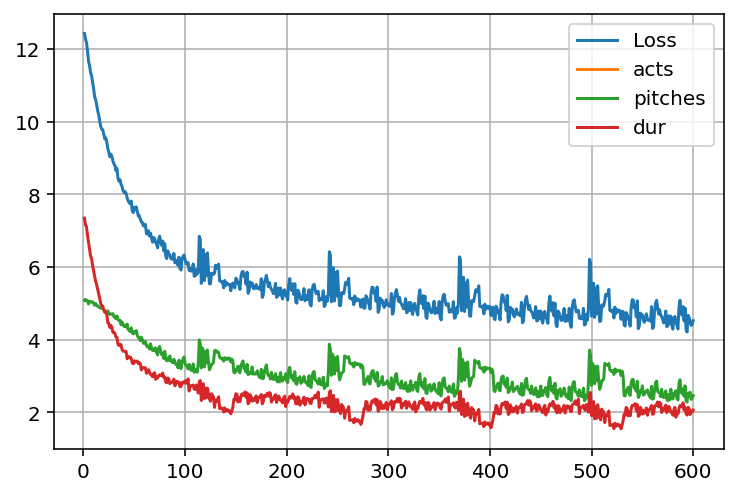

In [118]:
losses = checkpoint['losses']

plt.plot(range(1, len(losses['tot'])+1), losses['tot'], label='Loss')
plt.plot(range(1, len(losses['acts'])+1), losses['acts'], label='acts')
plt.plot(range(1, len(losses['pitches'])+1), losses['pitches'], label='pitches')
plt.plot(range(1, len(losses['dur'])+1), losses['dur'], label='dur')
#plt.plot(range(1, len(losses['kld'])+1), losses['kld'], label='kld')
plt.grid()
plt.legend()

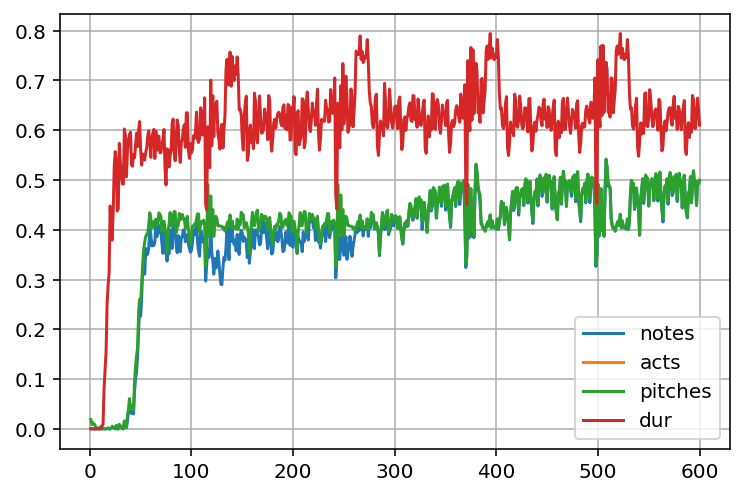

In [119]:
accs = checkpoint['accuracies']
plt.plot(range(1, len(accs['notes'])+1), accs['notes'], label='notes')
plt.plot(range(1, len(accs['acts'])+1), accs['acts'], label='acts')
plt.plot(range(1, len(accs['pitches'])+1), accs['pitches'], label='pitches')
plt.plot(range(1, len(accs['dur'])+1), accs['dur'], label='dur')
plt.grid()
plt.legend()

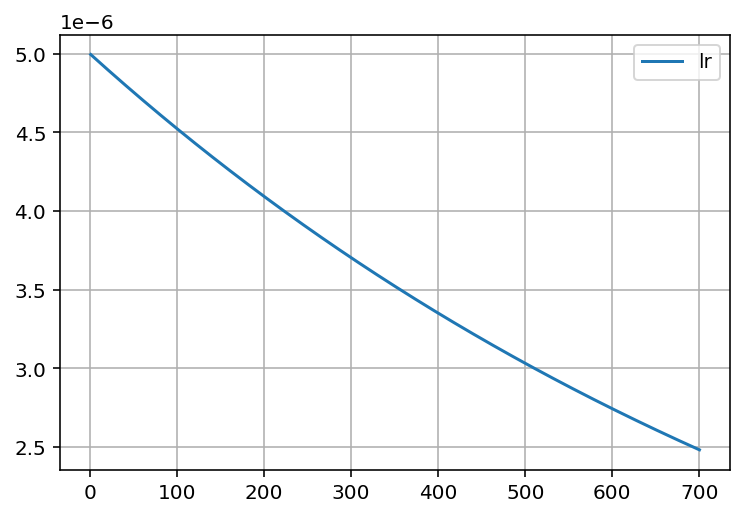

In [23]:
plt.plot(range(1, len(checkpoint['lrs'])+1), checkpoint['lrs'], label='lr')
plt.grid()
plt.legend()

In [25]:
print("Last lr:", checkpoint['lrs'][-1])

Last lr: 2.4820570671554912e-06


Reconstruct

In [145]:
dataset[0][0].size()

torch.Size([4, 128, 16, 140])

Plot music and save it to disk

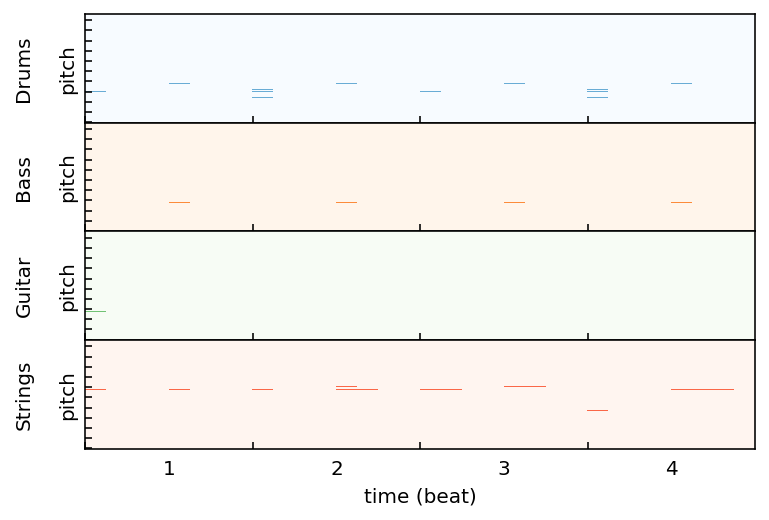

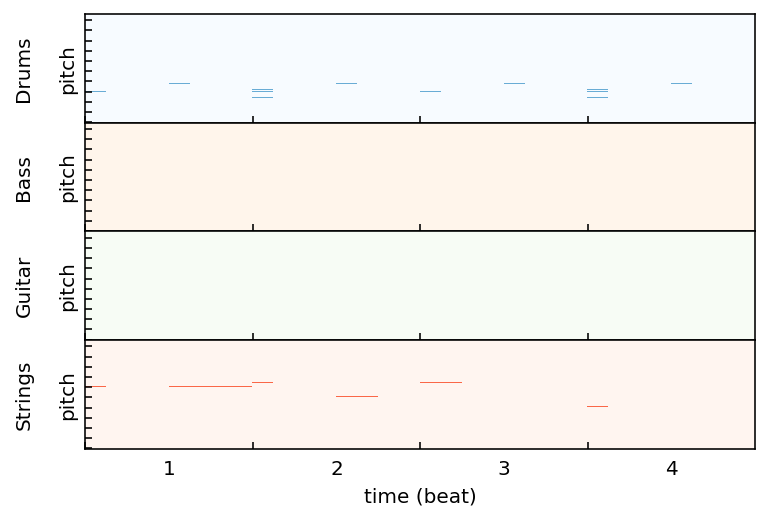

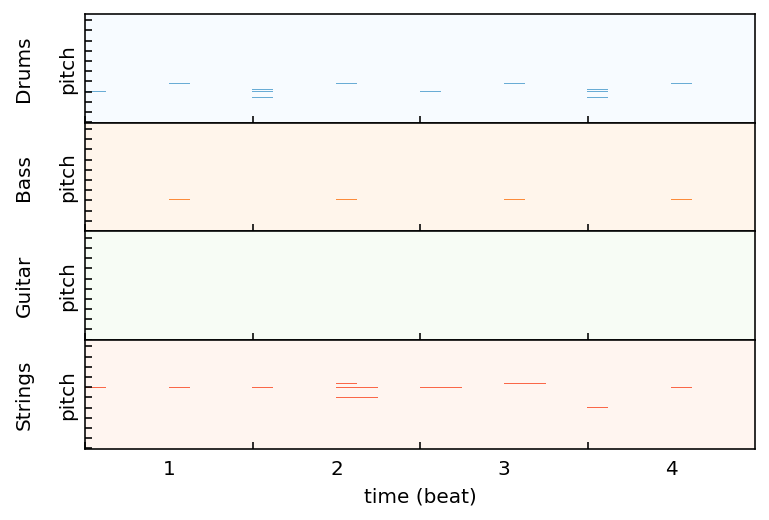

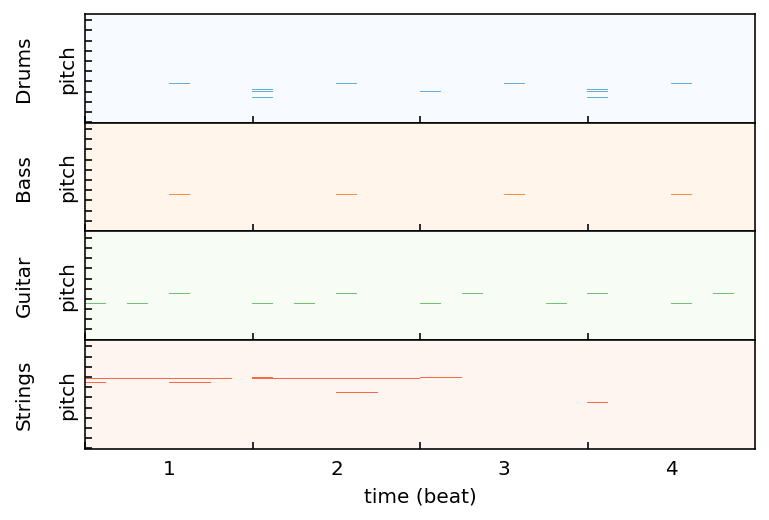

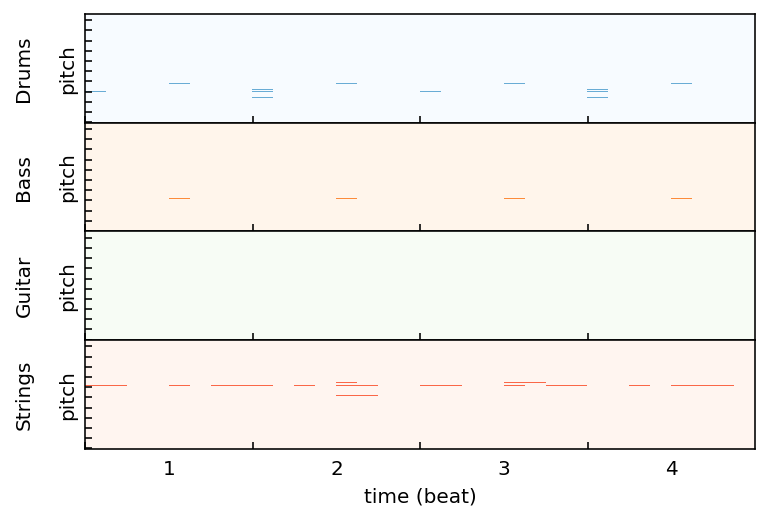

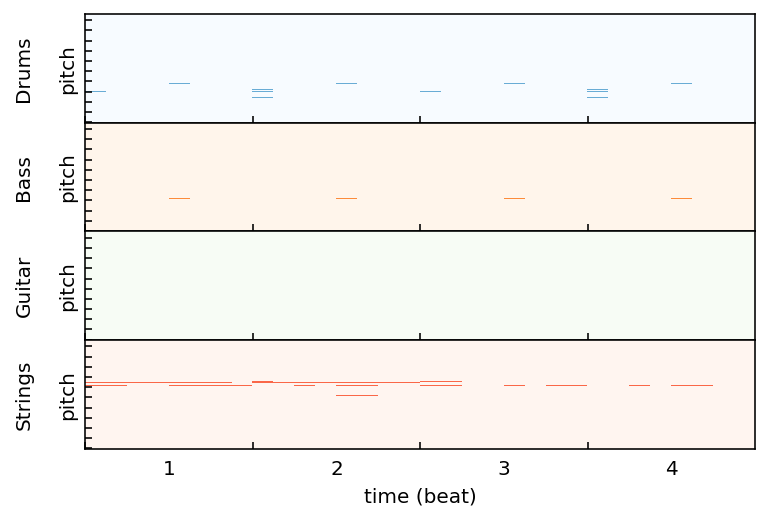

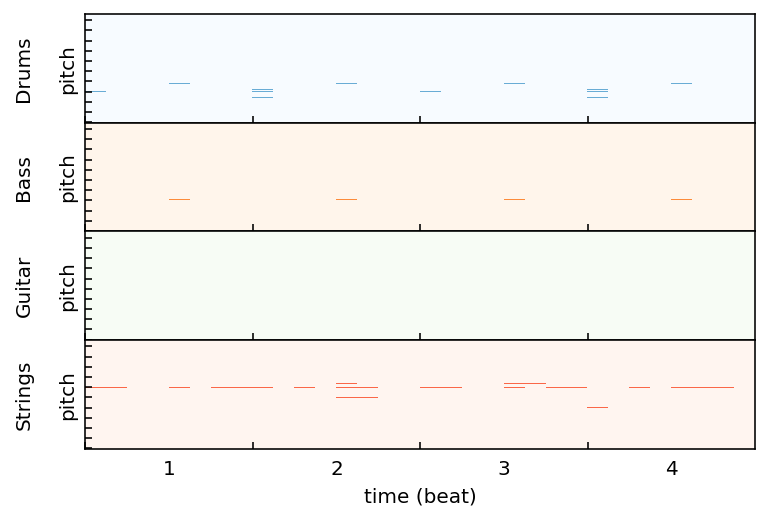

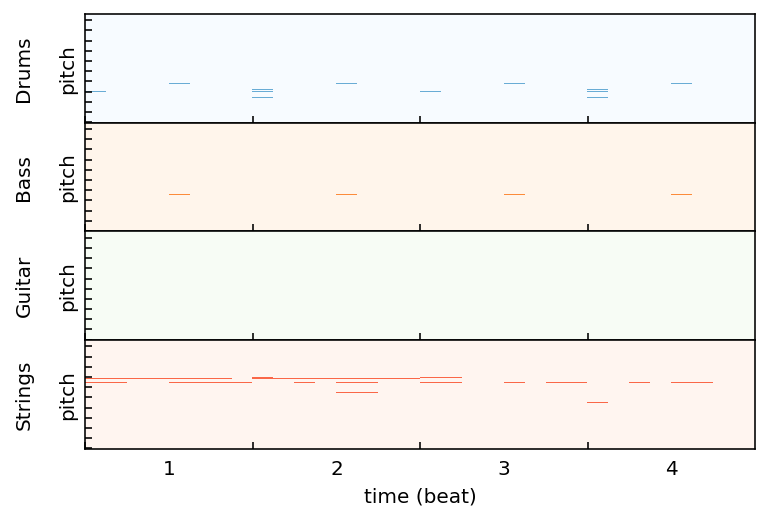

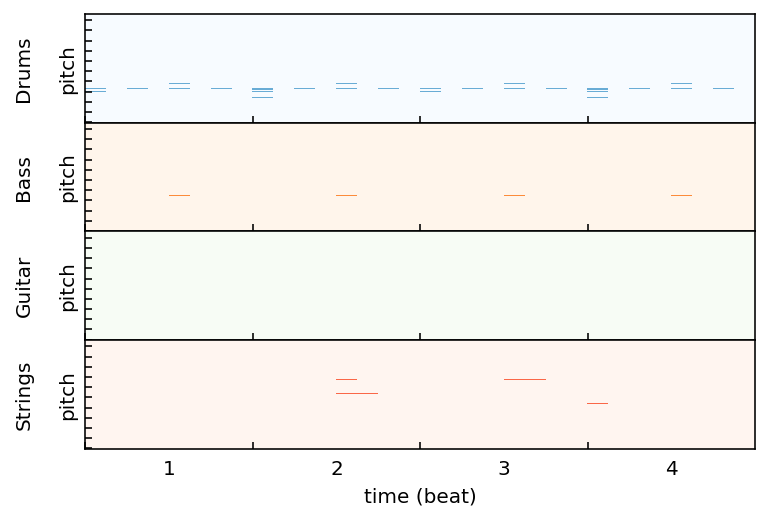

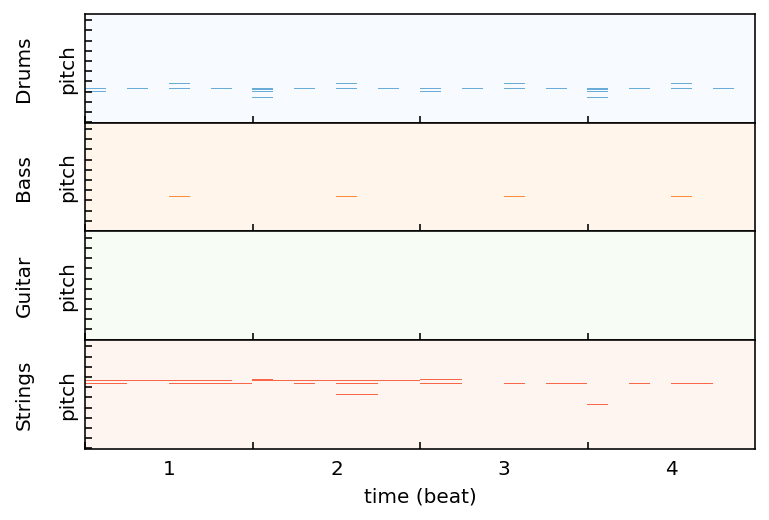

In [88]:
#tracks = [drum_track, bass_track, guitar_track, strings_track]
import copy

def from_tensor_to_muspy(music_tensor, track_data):
    
    powers = torch.tensor([2**n for n in reversed(range(9))], dtype=torch.float)
    tracks = []
    
    for tr in range(music_tensor.size(0)):
        
        notes = []
        
        for ts in range(music_tensor.size(1)):
            for note in range(music_tensor.size(2)):
                
                pitch = music_tensor[tr, ts, note, :131]
                pitch = torch.argmax(pitch)

                if pitch == 129:
                    break
                
                if pitch != 128:
                    dur = music_tensor[tr, ts, note, 131:]
                    dur = torch.dot(dur, powers).long()
                    
                    notes.append(muspy.Note(ts, pitch.item(), dur.item(), 64))
        
        if track_data[tr][0] == 'Drums':
            track = muspy.Track(name='Drums', is_drum=True, notes=copy.deepcopy(notes))
        else:
            track = muspy.Track(name=track_data[tr][0], 
                                program=track_data[tr][1],
                                notes=copy.deepcopy(notes))
        tracks.append(track)
    
    meta = muspy.Metadata(title='prova')
    music = muspy.Music(tracks=tracks, metadata=meta, resolution=RESOLUTION)
    
    return music


track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 41)]

prefix = "data/music/file"

for i in range(10):
    music_tensor = dataset[20+i][0]
    music = from_tensor_to_muspy(music_tensor, track_data)
    muspy.show_pianoroll(music, yticklabel='off', grid_axis='off')
    plt.savefig(prefix + str(i) + ".png")
    muspy.write_midi(prefix + str(i) + ".mid", music)

In [58]:
music

Music(metadata=Metadata(schema_version='0.1', title='prova'), resolution=32, tracks=[Track(program=0, is_drum=True, name='Drums', notes=[Note(time=0, pitch=45, duration=1, velocity=64), Note(time=8, pitch=45, duration=1, velocity=64), Note(time=16, pitch=45, duration=1, velocity=64), ...]), Track(program=34, is_drum=False, name='Bass', notes=[Note(time=0, pitch=30, duration=23, velocity=64), Note(time=23, pitch=32, duration=23, velocity=64), Note(time=47, pitch=32, duration=29, velocity=64)]), Track(program=1, is_drum=False, name='Guitar', notes=[Note(time=32, pitch=94, duration=5, velocity=64), Note(time=40, pitch=94, duration=5, velocity=64), Note(time=48, pitch=94, duration=5, velocity=64), ...]), ...])

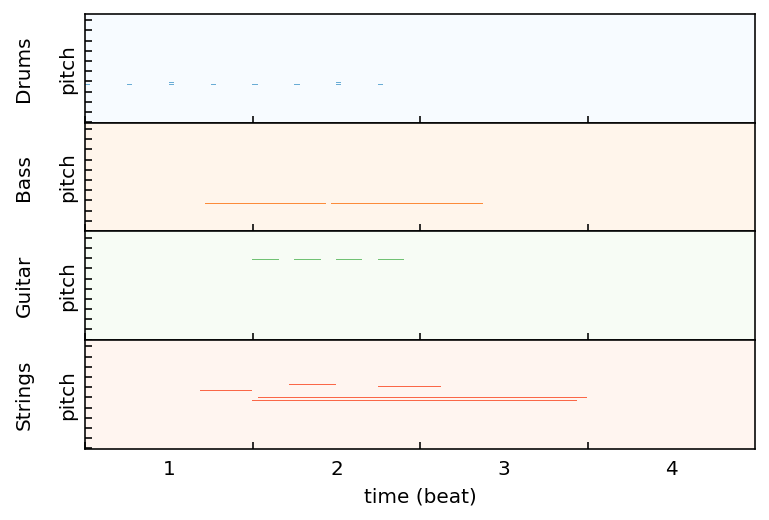

In [60]:
music_path = "data/music/file2.mid"
muspy.show_pianoroll(music, yticklabel='off', grid_axis='off')
plt.savefig('file2.png')
muspy.write_midi(music_path, music)

In [ ]:
print(dataset[0][0].size())
notes = []
notes.append(muspy.Note(1, 48, 20, 64))
drums = muspy.Track(is_drum=True)
bass = muspy.Track(program=34, notes=notes)
guitar = muspy.Track(program=27, notes=[])
strings = muspy.Track(program=42, notes=[muspy.Note(0, 100, 4, 64), muspy.Note(4, 91, 20, 64)])

tracks = [drums, bass, guitar, strings]

meta = muspy.Metadata(title='prova')
music = muspy.Music(tracks=tracks, metadata=meta, resolution=32)

In [91]:
!ls data/lmd_matched/M/T/O/TRMTOBP128E07822EF/63edabc86c087f07eca448b0edad53c3.mid

63edabc86c087f07eca448b0edad53c3.mid


# Stuff

In [ ]:
from typing import Optional, Union, Tuple
from torch_geometric.typing import OptTensor, Adj

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter as Param
from torch.nn import Parameter
from torch_scatter import scatter
from torch_sparse import SparseTensor, matmul, masked_select_nnz
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import glorot, zeros


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (Tensor, Tensor) -> Tensor
    pass


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (SparseTensor, Tensor) -> SparseTensor
    pass


def masked_edge_index(edge_index, edge_mask):
    if isinstance(edge_index, Tensor):
        return edge_index[:, edge_mask]
    else:
        return masked_select_nnz(edge_index, edge_mask, layout='coo')


class RGCNConv(MessagePassing):
    r"""The relational graph convolutional operator from the `"Modeling
    Relational Data with Graph Convolutional Networks"
    <https://arxiv.org/abs/1703.06103>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta}_{\textrm{root}} \cdot
        \mathbf{x}_i + \sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_r(i)}
        \frac{1}{|\mathcal{N}_r(i)|} \mathbf{\Theta}_r \cdot \mathbf{x}_j,

    where :math:`\mathcal{R}` denotes the set of relations, *i.e.* edge types.
    Edge type needs to be a one-dimensional :obj:`torch.long` tensor which
    stores a relation identifier
    :math:`\in \{ 0, \ldots, |\mathcal{R}| - 1\}` for each edge.

    .. note::
        This implementation is as memory-efficient as possible by iterating
        over each individual relation type.
        Therefore, it may result in low GPU utilization in case the graph has a
        large number of relations.
        As an alternative approach, :class:`FastRGCNConv` does not iterate over
        each individual type, but may consume a large amount of memory to
        compensate.
        We advise to check out both implementations to see which one fits your
        needs.

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
            In case no input features are given, this argument should
            correspond to the number of nodes in your graph.
        out_channels (int): Size of each output sample.
        num_relations (int): Number of relations.
        num_bases (int, optional): If set to not :obj:`None`, this layer will
            use the basis-decomposition regularization scheme where
            :obj:`num_bases` denotes the number of bases to use.
            (default: :obj:`None`)
        num_blocks (int, optional): If set to not :obj:`None`, this layer will
            use the block-diagonal-decomposition regularization scheme where
            :obj:`num_blocks` denotes the number of blocks to use.
            (default: :obj:`None`)
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"mean"`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        num_relations: int,
        num_bases: Optional[int] = None,
        num_blocks: Optional[int] = None,
        aggr: str = 'mean',
        root_weight: bool = True,
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(aggr=aggr, node_dim=0, **kwargs)

        if num_bases is not None and num_blocks is not None:
            raise ValueError('Can not apply both basis-decomposition and '
                             'block-diagonal-decomposition at the same time.')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_relations = num_relations
        self.num_bases = num_bases
        self.num_blocks = num_blocks

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
        self.in_channels_l = in_channels[0]

        if num_bases is not None:
            self.weight = Parameter(
                torch.Tensor(num_bases, in_channels[0], out_channels))
            self.comp = Parameter(torch.Tensor(num_relations, num_bases))

        elif num_blocks is not None:
            assert (in_channels[0] % num_blocks == 0
                    and out_channels % num_blocks == 0)
            self.weight = Parameter(
                torch.Tensor(num_relations, num_blocks,
                             in_channels[0] // num_blocks,
                             out_channels // num_blocks))
            self.register_parameter('comp', None)

        else:
            self.weight = Parameter(
                torch.Tensor(num_relations, in_channels[0], out_channels))
            self.register_parameter('comp', None)

        if root_weight:
            self.root = Param(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Param(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.comp)
        glorot(self.root)
        zeros(self.bias)


    def forward(self, x: Union[OptTensor, Tuple[OptTensor, Tensor]],
                edge_index: Adj, edge_type: OptTensor = None):
        r"""
        Args:
            x: The input node features. Can be either a :obj:`[num_nodes,
                in_channels]` node feature matrix, or an optional
                one-dimensional node index tensor (in which case input features
                are treated as trainable node embeddings).
                Furthermore, :obj:`x` can be of type :obj:`tuple` denoting
                source and destination node features.
            edge_type: The one-dimensional relation type/index for each edge in
                :obj:`edge_index`.
                Should be only :obj:`None` in case :obj:`edge_index` is of type
                :class:`torch_sparse.tensor.SparseTensor`.
                (default: :obj:`None`)
        """

        # Convert input features to a pair of node features or node indices.
        x_l: OptTensor = None
        if isinstance(x, tuple):
            x_l = x[0]
        else:
            x_l = x
        if x_l is None:
            x_l = torch.arange(self.in_channels_l, device=self.weight.device)

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        # propagate_type: (x: Tensor)
        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device)

        weight = self.weight
        if self.num_bases is not None:  # Basis-decomposition =================
            weight = (self.comp @ weight.view(self.num_bases, -1)).view(
                self.num_relations, self.in_channels_l, self.out_channels)

        if self.num_blocks is not None:  # Block-diagonal-decomposition =====

            if x_l.dtype == torch.long and self.num_blocks is not None:
                raise ValueError('Block-diagonal decomposition not supported '
                                 'for non-continuous input features.')

            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                h = self.propagate(tmp, x=x_l, size=size)
                h = h.view(-1, weight.size(1), weight.size(2))
                h = torch.einsum('abc,bcd->abd', h, weight[i])
                out += h.contiguous().view(-1, self.out_channels)

        else:  # No regularization/Basis-decomposition ========================
            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)

                if x_l.dtype == torch.long:
                    out += self.propagate(tmp, x=weight[i, x_l], size=size)
                else:
                    h = self.propagate(tmp, x=x_l, size=size)
                    out = out + (h @ weight[i])

        root = self.root
        if root is not None:
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        if self.bias is not None:
            out += self.bias

        return out


    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_relations={self.num_relations})')

next edges

In [ ]:
import itertools

a = np.random.randint(2, size=(4,8))
a_t = a.transpose()
print(a_t)
inds = np.stack(np.where(a_t == 1)).transpose()
ts_acts = np.any(a_t, axis=1)
ts_inds = np.where(ts_acts)[0]

labels = np.arange(32).reshape(4, 8).transpose()
print(labels)

next_edges = []
for i in range(len(ts_inds)-1):
    ind_s = ts_inds[i]
    ind_e = ts_inds[i+1]
    s = inds[inds[:,0] == ind_s]
    e = inds[inds[:,0] == ind_e]
    e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
    edges = [(labels[tuple(e[0])],labels[tuple(e[1])], ind_e-ind_s) for e in e_inds]
    next_edges.extend(edges)

print(next_edges)
    

onset edges

In [ ]:
onset_edges = []
print(a_t)
print(labels)

for i in ts_inds:
    ts_acts_inds = list(inds[inds[:,0] == i])
    if len(ts_acts_inds) < 2:
        continue
    e_inds = list(itertools.combinations(ts_acts_inds, 2))
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], 0) for e in e_inds]
    inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
    onset_edges.extend(edges)
    onset_edges.extend(inv_edges)

print(onset_edges)


track edges

In [ ]:
print(a_t)
print(labels)
track_edges = []

for track in range(a_t.shape[1]):
    tr_inds = list(inds[inds[:,1] == track])
    e_inds = [(tr_inds[i],
               tr_inds[i+1]) for i in range(len(tr_inds)-1)]
    print(e_inds)
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], e[1][0]-e[0][0]) for e in e_inds]
    track_edges.extend(edges)

print(track_edges)

In [ ]:
track_edges = np.array(track_edges)
onset_edges = np.array(onset_edges)
np.concatenate((track_edges, onset_edges)).shape

In [ ]:
pip install pypianoroll

In [ ]:
import pypianoroll

In [ ]:
multitrack = pypianoroll.read("tests_fur-elise.mid")
print(multitrack)

In [ ]:
multitrack.tracks[0].pianoroll

In [ ]:
multitrack.plot()

In [ ]:
multitrack.trim(0, 12 * multitrack.resolution)
multitrack.binarize()

In [ ]:
multitrack.plot()

In [ ]:
multitrack.tracks[0].pianoroll.shape